In [4]:
import pandas as pd
import numpy as np

In [2]:
import sys
sys.path.insert(0, '/home/tegbe/2023/ccl/timeRobert/')  # Replace 'path/to/parent_directory' with the absolute path to the parent directory

from eda import exp

In [106]:
df = exp.import_data()
df_pdoil = df[['DATE', 'PD_Oil Rate (stb/day)']]


# Rename columns to generic names
df_pdoil = df_pdoil.rename(columns={'DATE': 'ds', 'PD_Oil Rate (stb/day)': "y"})

df_pdoil_clean = df_pdoil.dropna(axis=0)

# Split data frame to train and test
X_train, y_train, X_test, y_test = exp.train_test_split_by_date(df_pdoil_clean, 'ds', 'y', '1999-01-01')

df_train = pd.concat([X_train, y_train], axis=1)
df_test =pd.concat([X_test, y_test], axis=1)

In [107]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [108]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

In [109]:
def create_windows(train_data, window_size=3):
    X, y = [], []
    for i in range(len(train_data) - window_size):
        window = train_data[i:(i + window_size)]
        X.append(window)
        y.append(train_data[i + window_size])
    return np.array(X), np.array(y)

# Splitting train data into input windows and output
X_train_windows, y_train_windows = create_windows(y_train.values)
X_test_windows, y_test_windows = create_windows(y_test.values)

# Perform splits on the date columns as well
_, ds_train_windows = create_windows(X_train.values)
_, ds_test_windows = create_windows(X_test.values)

In [110]:
y_train_windows.shape, ds_train_windows.flatten().shape

((244,), (244,))

In [111]:
# Initialize Random Forest and XGBoost models
rf_model = RandomForestRegressor()

# Fit Random Forest and XGBoost models on the input windows and output
rf_model.fit(X_train_windows, y_train_windows)

rf_forecast = rf_model.predict(X_test_windows)
rf_mape = mean_absolute_percentage_error(y_test_windows, rf_forecast)
print("Random Forest MAPE:", rf_mape)


Random Forest MAPE: 0.23646306224074198


In [112]:
X_test.values.shape, rf_forecast.shape, y_test_windows.shape

((10, 1), (7,), (7,))

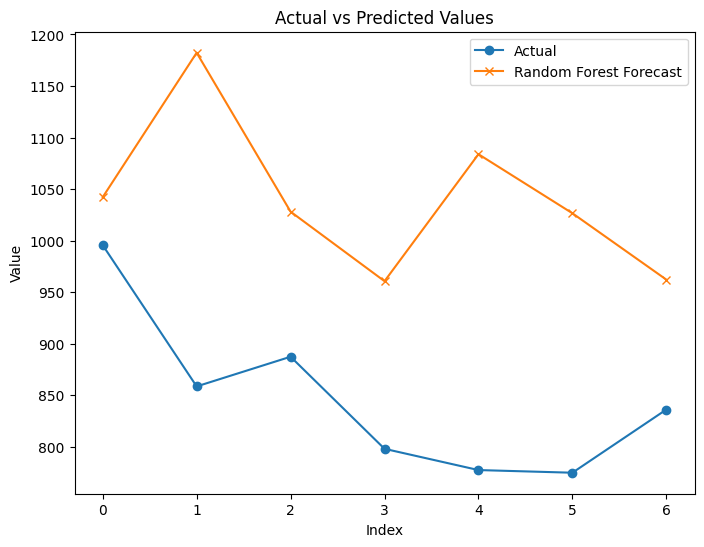

In [113]:
import matplotlib.pyplot as plt

def plot_forecast(y_test, y_forecast):
    # Plotting actual vs predicted values
    plt.figure(figsize=(8, 6))
    plt.plot(y_test, label='Actual', marker='o')
    plt.plot(y_forecast, label='Random Forest Forecast', marker='x')
    # Use xgb_forecast for XGBoost or any other forecast
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Actual vs Predicted Values')
    plt.legend()
    plt.show()

plot_forecast(y_test_windows, rf_forecast)

In [114]:

xgb_model = XGBRegressor()

xgb_model.fit(X_train_windows, y_train_windows)

xgb_forecast = xgb_model.predict(X_test_windows)
xgb_mape = mean_absolute_percentage_error(y_test_windows, xgb_forecast)
print("XGBoost MAPE:", xgb_mape)


XGBoost MAPE: 0.16404454799279208


In [115]:
import matplotlib.pyplot as plt

def plot_forecast(y_test, y_forecast, ds):
    # Plotting actual vs predicted values
    plt.figure(figsize=(8, 6))
    plt.plot(ds, y_test, label='Actual', marker='o')
    plt.plot(ds, y_forecast, label='Random Forest Forecast', marker='x')
    # Use xgb_forecast for XGBoost or any other forecast
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Actual vs Predicted Values')
    plt.legend()
    plt.show()

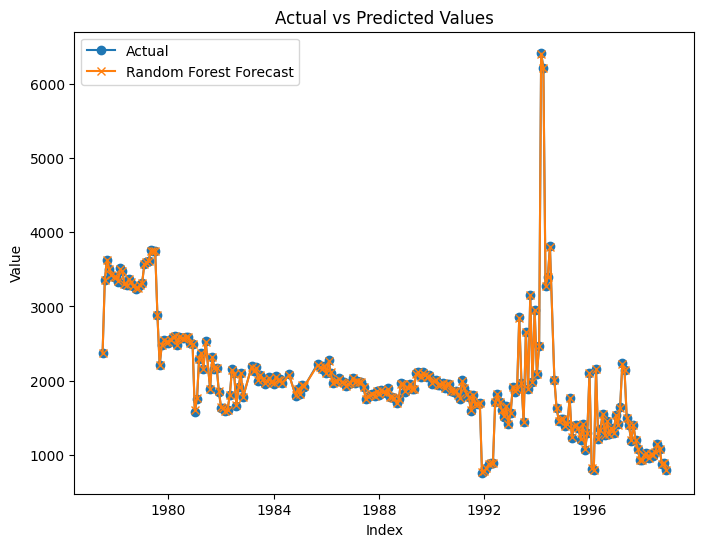

In [116]:
xgb_train_forecast = xgb_model.predict(X_train_windows)
plot_forecast(y_train_windows, xgb_train_forecast, ds_train_windows.flatten())

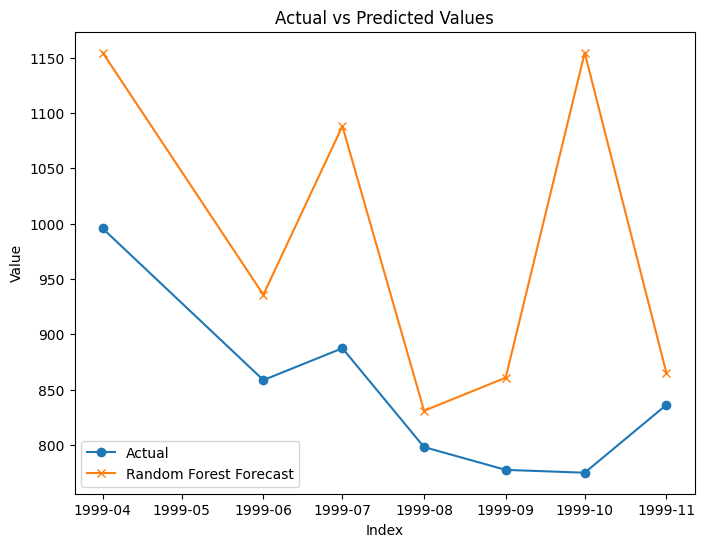

In [117]:
plot_forecast(y_test_windows, xgb_forecast, ds_test_windows.flatten())

In [118]:
y_test.shape, y_test_windows.shape

((10,), (7,))

In [119]:
xgb_test_forecast = xgb_model.predict(X_test_windows)

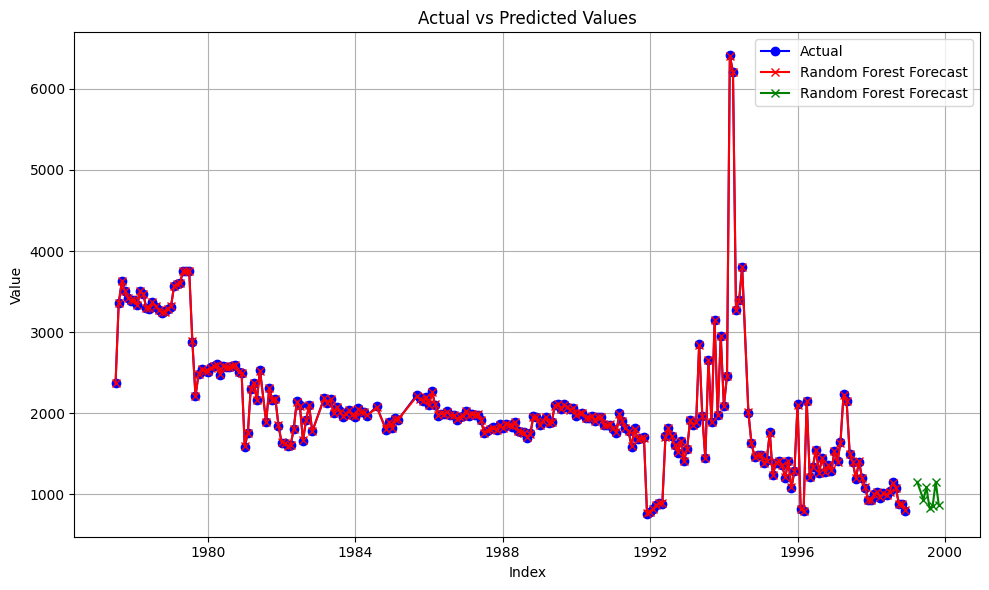

In [120]:
import matplotlib.pyplot as plt

#def plot_forecast(y_test, y_forecast, ds):
    # Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(ds_train_windows.flatten(), y_train_windows, color='b', label='Actual', marker='o')
plt.plot(ds_train_windows.flatten(), xgb_train_forecast, color='r', label='Random Forest Forecast', marker='x')
plt.plot(ds_test_windows.flatten(), xgb_test_forecast, color='g', label='Random Forest Forecast', marker='x')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()